#Preparation



##Mount colab

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the code and datasets.
FOLDERNAME = 'deep_perception/final_project'

Mounted at /content/drive


In [ ]:
%cd "./drive/MyDrive/deep_perception/final_project/archive"

/content/drive/MyDrive/deep_perception/final_project/archive


##Imports

In [710]:
import cv2
import numpy as np
import random
import torch
import torchvision
import cv2
from PIL import Image
from torchvision.transforms import transforms as transforms
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from math import sqrt, floor, ceil, log, e
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, models
import urllib.request
from copy import deepcopy
from io import BytesIO

##Download models

###Object detection

In [711]:
# initialize the model
od_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, 
                                                           num_classes=91)
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
od_model.to(device).eval()
...

Ellipsis

###Depth map

In [712]:
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
midas_transform = midas_transforms.default_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


### Image features extractor

In [713]:
vgg = models.vgg19(pretrained=True)

In [714]:
def freeze_network(net):
  '''
  The function freezes all layers of a pytorch network (net).
  '''
  for param in net.parameters():
      param.requires_grad = False

In [715]:
# freeze all VGG parameters
freeze_network(vgg)

In [716]:
def replace_max_pooling(net):
    '''
    The function replaces max pooling layers with average pooling layers with 
    the following properties: kernel_size=2, stride=2, padding=0.
    '''
    current_features = net.features

    for i, feature in enumerate(current_features):
        if isinstance(feature, torch.nn.MaxPool2d):
            current_features[i] = torch.nn.AvgPool2d(kernel_size=2, stride=2, padding=0)

In [717]:
# replace max pooling with avg pooling
replace_max_pooling(vgg)

In [718]:
# move the model to the GPU
vgg = vgg.to(device).eval()

##Set the image

In [719]:
content_path = "rhino/002.jpg"
# content_path = "elephant/054.jpg"
# content_path = "zebra/073.jpg"
# content_path = "buffalo/051.jpg"
# content_path = "my/sun.jpeg"

# Image Files

Before starting implementing the algorithm, we will first define two utility  functions:  
1. Transferring images to pytorch tensors.  
2. Transfering tensors to images.

In [720]:
def image_to_numpy(image,new_size=None):
  if new_size is not None:
    image = image.resize(new_size,Image.ANTIALIAS)
  return image.convert('RGB') 

In [721]:
def image_path_to_numpy(image_path,new_size=None):
  # load image into a numpy array from the given path
  image = Image.open(image_path)
  return image_to_numpy(image,new_size)

In [722]:
def image_to_tensor(image_numpy, max_size=400, shape=None):
  
  # crop image if image is too big
  if max(image_numpy.size) > max_size:
    size = max_size
  else:
    size = max(image_numpy.size)
	
  size = (size, int(1.5*size))
  # if shape is given use it
  if shape is not None:
    size = shape
  
  # resize and normalize the image
  in_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
  
  image = in_transform(image_numpy)[:3, :, :].unsqueeze(0)
  
  return image

In [723]:
def tensor_to_numpy(image_tensor):
  image = image_tensor.to("cpu").clone().detach()
  image = image.numpy().squeeze()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
  image = image.clip(0, 1)
  
  return image

#Object detection

In [724]:
def get_od_model_outputs(image, model, threshold):
    with torch.no_grad():
        # forward pass of the image through the modle
        outputs = model(image)
    
    # get all the scores
    scores = list(outputs[0]['scores'].detach().cpu().numpy())
    # index of those scores which are above a certain threshold
    thresholded_preds_inidices = [idx for idx, score in enumerate(scores) if score > threshold]
    thresholded_preds_count = len(thresholded_preds_inidices)
    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(i[0], i[1]), (i[2], i[3])]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:thresholded_preds_count]
    return boxes

In [725]:
def get_od_objects(model,content_path, filter=0.5):
  image = Image.open(content_path).convert('RGB')
  # transform to convert the image to tensor
  transform_image_to_tensor = transforms.Compose([
      transforms.ToTensor()
  ])
  image = transform_image_to_tensor(image)
  # add a batch dimension
  image = image.unsqueeze(0).to(device)
  return get_od_model_outputs(image, od_model, filter)


#Create depth style

In [726]:
def get_depth_map(content_path):
  # load image
  img = cv2.imread(content_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  input_batch = midas_transform(img).to(device)

  # get depth map
  with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
          prediction.unsqueeze(1),
          size=img.shape[:2],
          mode="bicubic",
          align_corners=False,
      ).squeeze()

  output = prediction.cpu().numpy()
  return output

In [727]:
def convert_depth_map_bw(depth_map, new_size=None):
  # create a black-white theme version of the depth map, and return it.
  fig = plt.figure()
  plt.axis('off')

  #display the image onto a grayscale plot
  plt.set_cmap("gray")
  plt.imshow(depth_map)

  #save to the plot to a temp bytes IO and then read from it as an Image
  temp_image_mem = BytesIO()
  fig.savefig(temp_image_mem, dpi=fig.dpi, bbox_inches='tight', pad_inches=0)
  image = Image.open(temp_image_mem)
  img = image_to_numpy(image, new_size)

  return img

In [728]:
def get_depth_style(content_path, new_size=None):
  depth_map = get_depth_map(content_path)
  depth_map_bw = convert_depth_map_bw(depth_map, new_size)
  return depth_map_bw  

#Create Final Style

In [729]:
def get_main_object_box(boxes):
  """
  return the largest box, surface area wise.
  if boxes list is empty, raise Exception
  """
  if len(boxes)==0:
    raise Exception("Could not find any object in the image...")
  return max(boxes,key=lambda obj:(obj[1][0]-obj[0][0])*(obj[1][1]-obj[0][1]))

def distance_2d(x,y,x2,y2):
  return sqrt((x-x2)**2+(y-y2)**2)

def light_gradient(mx,my,dbox,dbox_factor,x,y):
  """
  calculate the light removal factor of the pixel, based on mx, my
  """
  factor_from_middle = dbox/dbox_factor
  d = max(0,distance_2d(mx,my,x,y)-factor_from_middle)
  return d

def calc_div_factor(mean):
  """
  We want to decrease the flash's brightness to achieve a more realistic looking.
  We use the div_factor to divide the style image by and thus make it darker.
  Calculate the div factor, based on the mean of the image's pixels
  """
  # The brighter the style is, the bigger div_factor we nead to make it realistic,
  # thus, we know the div_factor depends on the mean brightness of the style.

  # We assume linear relation between the two. After measuring two states we
  # could calculate the liner equation relates the two.
  return mean/20+1

def calc_dbox_factor(r):
  """
  Calculate dbox_factor as a function of the ratio between the diagonals.
  The dbox_factor is used to make the weights of the style dependent also of the main object size.
  """
  # 1 / (1 - r) takes a value in the range [0, 1) and transforms it to the range [1, inf)
  r = 1 / (1 - r)
  
  # We use sigmoid function and multiply by a constant, to transform the value into the range [1.82, 2.5]
  # The values graduate slowly and thus the effect of the object's size is moderated.
  r = pow(e, -r)
  r = 1 / (1 + r)
  r = 2.5 * r
  return r

In [730]:
def create_final_style(content_path, model, depth_style):
  # convert the depth style to numpy
  ds_arr = np.asarray(depth_style).astype('float')
  # get objects
  boxes  = get_od_objects(model, content_path)
  # get the main object box
  main_object_box = get_main_object_box(boxes)
  # get box middle coordinates 
  mx = (main_object_box[0][0]+main_object_box[1][0])/2
  my = (main_object_box[0][1]+main_object_box[1][1])/2
  #get length of diagonal of the box
  dbox = distance_2d(main_object_box[0][0],main_object_box[0][1],main_object_box[1][0],main_object_box[1][1])
  #get length of diagonal of the whole image
  big_diag = distance_2d(0,0,ds_arr.shape[0],ds_arr.shape[1])
  #get the factor of dbox, based on the ratio between the two diagonals
  dbox_factor = calc_dbox_factor(dbox/big_diag)
  #get max light_gradient out of all image corners
  maxd = max([light_gradient(mx,my,dbox,dbox_factor,0,0),
              light_gradient(mx,my,dbox,dbox_factor,ds_arr.shape[1],0),
              light_gradient(mx,my,dbox,dbox_factor,0,ds_arr.shape[0]),
              light_gradient(mx,my,dbox,dbox_factor,ds_arr.shape[1],ds_arr.shape[0])])

  #set p as a function of dbox_factor
  p = 0.2*dbox_factor+1
  print(dbox/big_diag,dbox_factor,p)
  for y in range(ds_arr.shape[0]):
    for x in range(ds_arr.shape[1]):
      #transform each pixel, as a function of its distance from the middle of the main box
      d = (1-light_gradient(mx,my,dbox,dbox_factor,x,y)/maxd)**p
      ds_arr[y,x,:] = ds_arr[y,x,:]*d

  #remove brightness in another way, as a function of the mean of the whole image after the first transformation
  ds_arr //= calc_div_factor(np.mean(ds_arr))
  #convert to image and return
  ds_arr = ds_arr.astype('uint8')
  return Image.fromarray(ds_arr)

#Style Transfer

##### **2.1 Content Loss**

We start with implementing the content loss.  
The content loss will help us preserve the original content of the content image in the generated image.  
It is simply the mean squared difference between the target and content features.

More formally: Given a content image **C**, a target (generated) image **G** and a layer **L** the *Content Loss* is defined as

$$Loss_{content}(C,G,L) = \frac{1}{D_LH_LW_L}\sum_{ij}{(a[L](C)_{ij} - a[L](G)_{ij})^2}$$

where $a[L](C)_{ij}$ is the is the activation of the $i$-th filter at position $j$ in layer $L$ when passing an image $C$. Same for $a[L](G)_{ij}$.  
$D_L$ - Depth/number channels of the output of layer $L$  
$H_L$ - Height of the output of layer $L$  
$W_L$ - Width of the output of layer $L$

Before implementing the loss, let's implement a function that extracts features given a model and an image.

The paper suggests extracting features from several convolutional layers.  
Layer 21 will be used for the Content Loss and Layers 0, 5, 10, 19, 28 will be used for the Style Loss (which we will implement in the next section).

In [731]:
def get_features(net, image_tensor):
    ''' 
    The function runs a forward pass given an image and extracts the features for 
    several conv layers. It returns a dictionary where the keys are the
    layers name and the values are the features.
    '''
    layers_idx = ['0','5','10','19','21','28']
    features = {}
    for i,layer in enumerate(net.features):
      image_tensor = layer.forward(image_tensor)
      if str(i) in layers_idx:
        features[str(i)] = image_tensor
    return features

In [732]:
def calculate_content_loss(target_features, content_features, layer_id='21'):
  t = target_features[layer_id]
  c = content_features[layer_id]
  return F.mse_loss(t,c)

##### **2.2 Style Loss**

In [733]:
def get_style_weights(style_image, prop):
  res = torch.max(style_image)-style_image
  res /= torch.max(res)
  res = torch.exp(res)
  res = torch.pow(res,1.5)
  return res.to(device)*prop

In [734]:
def new_style_loss(target_image, style_image,prop):
  style_w = get_style_weights(style_image,prop)
  return F.mse_loss(torch.mul(target_image,style_w),torch.mul(style_image,style_w))

##### **2.3 Total Loss & Gradient Descent**

Now that we have both content and style loss we can add them up and perform gradient descent to change the generated image such that it decreases its loss after each iteration.


The total loss would be:  

$$Loss_{total} = Loss_{content}(C,G) + prop * Loss_{style}(S,G)$$

where alpha and beta are hyperparameters that weights each loss to control the tradeoff between content and style.

In [735]:
def style_transfer(vgg_model, content_tensor, style_tensor,
                   prop, n_iterations, learning_rate):
  '''
  The function runs the style transfer algorithm using a pretrained and freezed vgg_model,
  a content image tensor and style image tensor. It weights the content loss with alpha
  and style loss with beta. It runs for n_iterations.
  '''
  # creating a random image and set requires_grad to True
  target_image = torch.randn_like(content_tensor).requires_grad_(True).to(device)
  # extract content features
  content_features = get_features(vgg_model, content_tensor)
  # create optimizer to optimize the target image 
  optimizer = torch.optim.Adam([target_image],lr = learning_rate)
  for i in range(n_iterations):
    optimizer.zero_grad()

    target_features = get_features(vgg_model, target_image)
    content_loss = calculate_content_loss(content_features, target_features, "10")
    style_loss = new_style_loss(target_image,style_tensor,prop)
    total_loss = content_loss + style_loss

    total_loss.backward()
    optimizer.step()

    if i % 50 == 0:
      print(f"Iteration {i}, Total Loss: {total_loss.item():.2f}, Content Loss: {content_loss.item():.2f}, Style  Loss {style_loss.item():.2f}")
  
  return target_image

#Plotting

In [736]:
def plot_original_and_result(original,result):
  # display the images
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
  plt.axis('off')
  # content and style ims side-by-side
  ax1.imshow(tensor_to_numpy(original))
  ax1.set_title("Original Image")
  ax2.imshow(tensor_to_numpy(result))
  ax2.set_title("Result Image")

In [737]:
def plot_result(result):
  fig, ax1 = plt.subplots(1, figsize=(20, 10))
  plt.axis('off')
  # content and style ims side-by-side
  ax1.imshow(tensor_to_numpy(result))
  ax1.set_title("Result Image")

#Operate

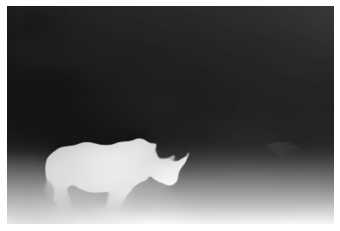

In [738]:
content_np = image_path_to_numpy(content_path)
depth_style_np = get_depth_style(content_path,new_size = content_np.size)

0.4250583389596959 2.1264975197499623 1.4252995039499925


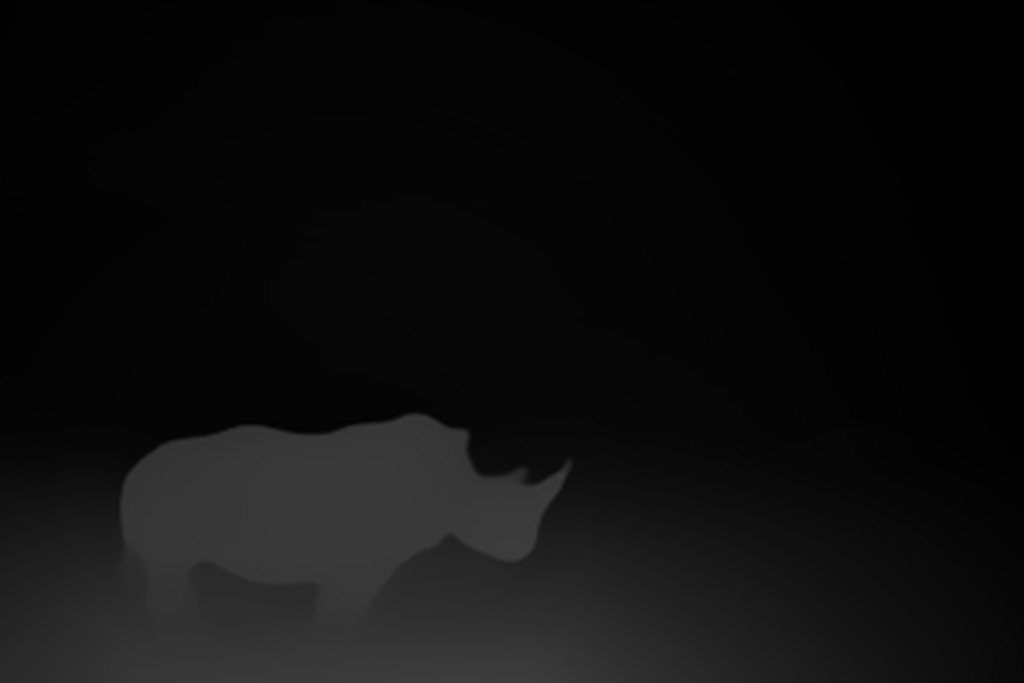

In [739]:
style_np = create_final_style(content_path, od_model, depth_style_np)
style_np

In [740]:
content_tensor = image_to_tensor(content_np).to(device)
style_tensor = image_to_tensor(style_np).to(device)

In [741]:
alpha=1
beta=1.5
final_image_tensor = style_transfer(vgg, content_tensor, style_tensor,
                             sqrt(beta/alpha), n_iterations=500, learning_rate=0.02)

Iteration 0, Total Loss: 77.82, Content Loss: 2.85, Style  Loss 74.97
Iteration 50, Total Loss: 32.18, Content Loss: 1.55, Style  Loss 30.63
Iteration 100, Total Loss: 12.65, Content Loss: 1.02, Style  Loss 11.63
Iteration 150, Total Loss: 4.97, Content Loss: 0.71, Style  Loss 4.25
Iteration 200, Total Loss: 2.05, Content Loss: 0.52, Style  Loss 1.53
Iteration 250, Total Loss: 0.95, Content Loss: 0.39, Style  Loss 0.56
Iteration 300, Total Loss: 0.54, Content Loss: 0.31, Style  Loss 0.23
Iteration 350, Total Loss: 0.40, Content Loss: 0.28, Style  Loss 0.12
Iteration 400, Total Loss: 0.37, Content Loss: 0.28, Style  Loss 0.09
Iteration 450, Total Loss: 0.36, Content Loss: 0.28, Style  Loss 0.09


#Final result

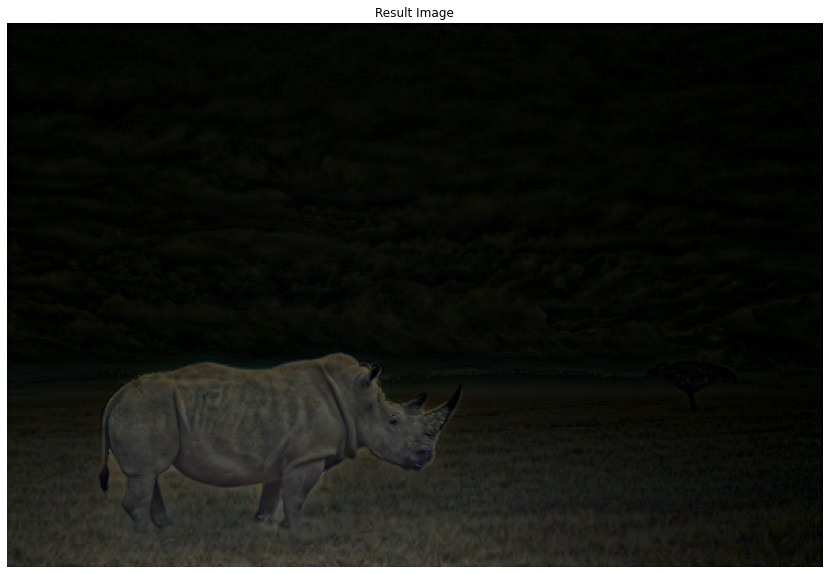

In [742]:
plot_result(final_image_tensor)

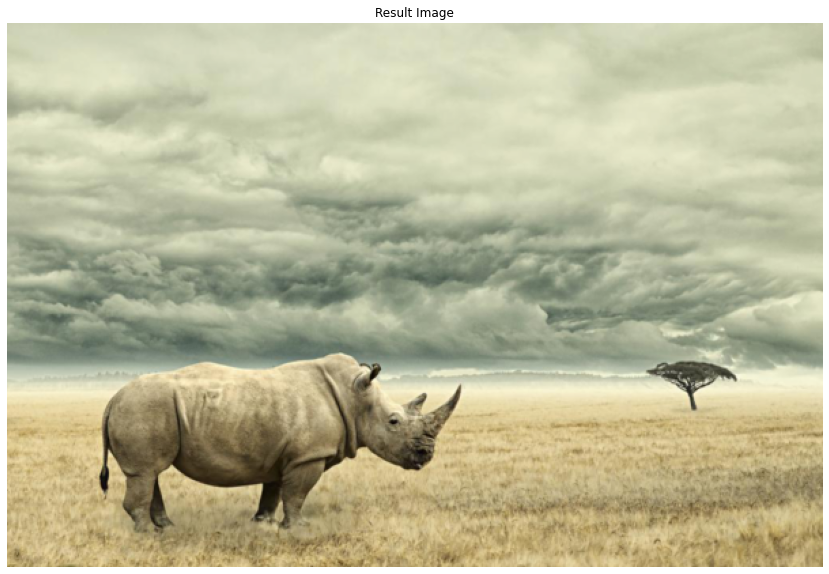

In [743]:
plot_result(content_tensor)

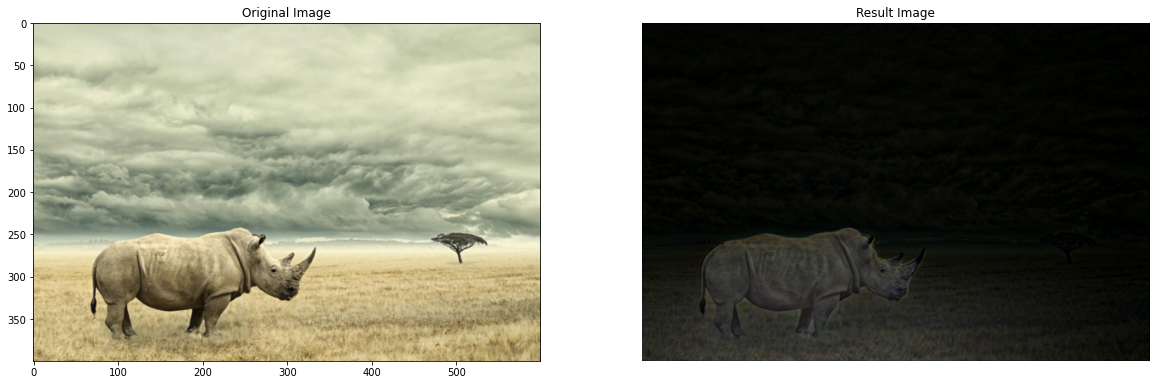

In [744]:
plot_original_and_result(content_tensor, final_image_tensor)